In [5]:
from pathlib import Path
import pandas as pd
from carps.analysis.gather_data import normalize_logs, get_interpolated_performance_df, load_logs, process_logs

def load_set(paths: list[str], set_id: str = "unknown") -> tuple[pd.DataFrame, pd.DataFrame]:
    logs = []
    for p in paths:
        fn = Path(p) / "trajectory.parquet"
        if not fn.is_file():
            fn = Path(p) / "logs.parquet"
        logs.append(pd.read_parquet(fn))

    df = pd.concat(logs).reset_index(drop=True)
    df_cfg = pd.concat([pd.read_parquet(Path(p) / "logs_cfg.parquet") for p in paths]).reset_index(drop=True)
    df["set"] = set_id
    return df, df_cfg

scenario = "blackbox"
set_id = "full"
paths = ["../runs/SMAC3-BlackBoxFacade", "../runs/RandomSearch", "../runs/Nevergrad-CMA-ES"]

D = []
for rundir in paths:
    df, df_cfg = load_set([rundir], set_id="full")
    D.append(df)

df = pd.concat(D).reset_index(drop=True)
del D

df = normalize_logs(df)

normalize_performance = False
perf_col = "trial_value__cost_inc_norm" if normalize_performance else "trial_value__cost_inc"

In [84]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from carps.utils.pareto_front import pareto



performance_fn = Path("/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/subselection/data/BB/default/df_crit.csv")
performance = pd.read_csv(performance_fn)
performance["problem_id"] = performance["problem_id"].apply(lambda x: "bbob/" + x if x.startswith("noiseless") else x)
problem_ids = list(performance["problem_id"])
n_problems = len(problem_ids)
subset_size = 30

use_mean = False
aggregate_func = lambda x: x
if use_mean:
    aggregate_func = np.mean


path_subset_dev = performance_fn.parent / f"subset_{subset_size}.csv"
path_subset_test = performance_fn.parent / f"subset_complement_subset_{subset_size}.csv"
subset_dev = pd.read_csv(path_subset_dev)
subset_test = pd.read_csv(path_subset_test)
problem_ids_dev = subset_dev["problem_id"].to_list()
problem_ids_test = subset_test["problem_id"].to_list()

seeds = np.arange(0, 10)
performance["benchmark_id"] = performance["problem_id"].apply(lambda x: x.split("/")[0])
benchmark_ids = list(performance["benchmark_id"].unique())

p_cols = [c for c in performance.columns if c not in ["problem_id", "benchmark_id"]]

mean_ranking_full = performance[p_cols].rank(axis=1).apply(aggregate_func)
mean_ranking_full["problem_id"] = performance["problem_id"] if not use_mean else "mean_problem"
mean_ranking_full["set"] = "full"
mean_ranking_full["split"] = -1
mean_ranking_full["seed"] = -1

mean_ranking_dev = subset_dev[p_cols].rank(axis=1).apply(aggregate_func)
mean_ranking_dev["problem_id"] = subset_dev["problem_id"] if not use_mean else "mean_problem"
mean_ranking_dev["set"] = "discrepancy_dev"
mean_ranking_dev["split"] = -1
mean_ranking_dev["seed"] = -1

mean_ranking_test = subset_test[p_cols].rank(axis=1).apply(aggregate_func)
mean_ranking_test["problem_id"] = subset_test["problem_id"] if not use_mean else "mean_problem"
mean_ranking_test["set"] = "discrepancy_test"
mean_ranking_test["split"] = -1
mean_ranking_test["seed"] = -1

# easiest
costs = performance[p_cols].values
ids = pareto(-costs)
pareto_performance = performance.iloc[ids]
mean_ranking_pareto_easiest = pareto_performance[p_cols].rank(axis=1).apply(aggregate_func)
mean_ranking_pareto_easiest["problem_id"] = pareto_performance["problem_id"] if not use_mean else "mean_problem"
mean_ranking_pareto_easiest["set"] = "pareto_full_easiest"
mean_ranking_pareto_easiest["split"] = -1
mean_ranking_pareto_easiest["seed"] = -1

# hardest
costs = performance[p_cols].values
ids = pareto(costs)
pareto_performance = performance.iloc[ids]
mean_ranking_pareto_hardest = pareto_performance[p_cols].rank(axis=1).apply(aggregate_func)
mean_ranking_pareto_hardest["problem_id"] = pareto_performance["problem_id"] if not use_mean else "mean_problem"
mean_ranking_pareto_hardest["set"] = "pareto_full_hardest"
mean_ranking_pareto_hardest["split"] = -1
mean_ranking_pareto_hardest["seed"] = -1



ranking = []
ranking.append(mean_ranking_full)
ranking.append(mean_ranking_dev)
ranking.append(mean_ranking_test)
ranking.append(mean_ranking_pareto_easiest)
ranking.append(mean_ranking_pareto_hardest)

n_splits = n_problems // (subset_size * 2)
print(n_splits)
X = performance.values
y = performance["benchmark_id"].to_numpy()

split_classes = [StratifiedShuffleSplit, ShuffleSplit]

for split_class in split_classes:
    for seed in seeds:
        sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.5, random_state=seed)
        sss.get_n_splits(X, y)
        for i, (train_index, test_index) in enumerate(sss.split(X, y)):
            D_dev = performance.iloc[train_index][p_cols].rank(axis=1).apply(aggregate_func)
            D_dev["problem_id"] = performance.iloc[train_index]["problem_id"] if not use_mean else "mean_problem"
            D_dev["set"] = f"{split_class.__name__}_dev"
            D_dev["split"] = i
            D_dev["seed"] = seed
            D_test = performance.iloc[test_index][p_cols].rank(axis=1).apply(aggregate_func)
            D_test["problem_id"] = performance.iloc[test_index]["problem_id"] if not use_mean else "mean_problem"
            D_test["set"] = f"{split_class.__name__}_test"
            D_test["split"] = i
            D_test["seed"] = seed
            ranking.extend([D_dev, D_test])

ranking


38


[      Nevergrad-CMA-ES  RandomSearch  SMAC3-BlackBoxFacade  \
 0                  2.0           2.0                   2.0   
 1                  3.0           2.0                   1.0   
 2                  3.0           1.5                   1.5   
 3                  3.0           2.0                   1.0   
 4                  2.0           2.0                   2.0   
 ...                ...           ...                   ...   
 2278               3.0           2.0                   1.0   
 2279               3.0           2.0                   1.0   
 2280               3.0           2.0                   1.0   
 2281               3.0           2.0                   1.0   
 2282               3.0           2.0                   1.0   
 
                        problem_id   set  split  seed  
 0            hpob/all/2010/125966  full     -1    -1  
 1            hpob/all/2039/125966  full     -1    -1  
 2            hpob/all/2039/125968  full     -1    -1  
 3            hpob

In [85]:
df_ranking = pd.DataFrame(ranking) if use_mean else pd.concat(ranking).reset_index(drop=True)
df_ranking = df_ranking.melt(id_vars=["set", "split", "seed", "problem_id"], value_vars=p_cols, var_name="optimizer_id", value_name="rank")
df_ranking

,set,split,seed,problem_id,optimizer_id,rank
0,full,-1,-1,hpob/all/2010/125966,Nevergrad-CMA-ES,2.0
1,full,-1,-1,hpob/all/2039/125966,Nevergrad-CMA-ES,3.0
2,full,-1,-1,hpob/all/2039/125968,Nevergrad-CMA-ES,3.0
3,full,-1,-1,hpob/all/2073/125966,Nevergrad-CMA-ES,3.0
4,full,-1,-1,hpob/all/2073/125968,Nevergrad-CMA-ES,2.0
...,...,...,...,...,...,...
5212282,ShuffleSplit_test,37,9,hpob/all/7609/3493,SMAC3-BlackBoxFacade,1.0
5212283,ShuffleSplit_test,37,9,hpob/all/6136/37,SMAC3-BlackBoxFacade,2.0
5212284,ShuffleSplit_test,37,9,hpob/all/5890/145857,SMAC3-BlackBoxFacade,2.0
5212285,ShuffleSplit_test,37,9,yahpo/rbv2_ranger/1501/None,SMAC3-BlackBoxFacade,1.0


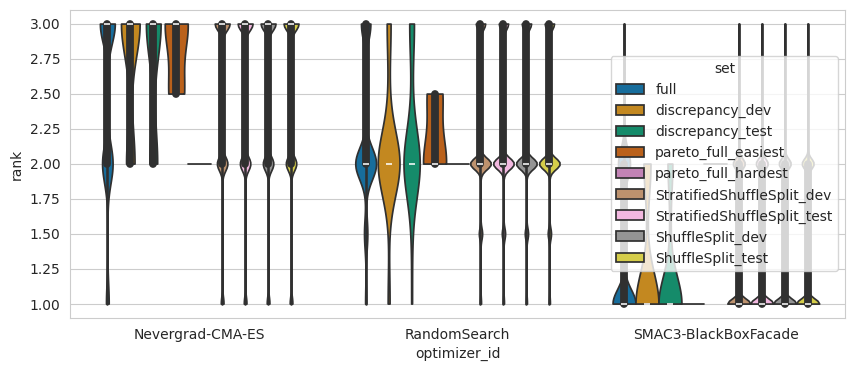

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax = sns.violinplot(data=df_ranking, x="optimizer_id", y="rank", hue="set", cut=0, ax=ax)
plt.show()

In [ ]:
D = df[df["problem_id"].isin(problem_ids)]